# Task
Implement a network intrusion detection system using an autoencoder and the NSL-KDD dataset.

## Load the nsl-kdd dataset



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hassan06/nslkdd")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'nslkdd' dataset.
Path to dataset files: /kaggle/input/nslkdd


In [ ]:
import pandas as pd


Define the column names and load the training and testing datasets into pandas DataFrames using the defined column names and specifying the delimiter.



In [ ]:
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "attack_type", "label"
]

train_df = pd.read_csv(f'{path}/KDDTrain+.txt', names=column_names, delimiter=',')
test_df = pd.read_csv(f'{path}/KDDTest+.txt', names=column_names, delimiter=',')

display(train_df.head())
display(test_df.head())

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,label
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


## Preprocess the data

Handle categorical features, scale numerical features, and prepare the data for the autoencoder. This will involve converting categorical features into numerical representations (e.g., one-hot encoding) and scaling numerical features to a common range.


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Identify categorical and numerical columns
categorical_cols = ['protocol_type', 'service', 'flag']
numerical_cols = [col for col in train_df.columns if col not in categorical_cols + ['attack_type', 'label']]

# Apply one-hot encoding
train_df_encoded = pd.get_dummies(train_df, columns=categorical_cols)
test_df_encoded = pd.get_dummies(test_df, columns=categorical_cols)

# Align columns - this is crucial for consistent feature sets
train_cols = list(train_df_encoded.columns)
test_cols = list(test_df_encoded.columns)

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    test_df_encoded[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    train_df_encoded[c] = 0

train_df_encoded = train_df_encoded[sorted(train_df_encoded.columns)]
test_df_encoded = test_df_encoded[sorted(test_df_encoded.columns)]

# Identify numerical columns after one-hot encoding
numerical_cols_encoded = [col for col in train_df_encoded.columns if col not in ['attack_type', 'label'] and train_df_encoded[col].dtype != 'uint8']


# Apply standard scaler
scaler = StandardScaler()
train_df_encoded[numerical_cols_encoded] = scaler.fit_transform(train_df_encoded[numerical_cols_encoded])
test_df_encoded[numerical_cols_encoded] = scaler.transform(test_df_encoded[numerical_cols_encoded])

# Separate features and labels
X_train = train_df_encoded.drop(['attack_type', 'label'], axis=1)
y_train = train_df_encoded[['attack_type', 'label']]

X_test = test_df_encoded.drop(['attack_type', 'label'], axis=1)
y_test = test_df_encoded[['attack_type', 'label']]

# Filter training data for normal traffic
X_train_normal = X_train[y_train['attack_type'] == 'normal']

display(X_train_normal.head())

,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_count,...,service_vmnet,service_whois,src_bytes,srv_count,srv_diff_host_rate,srv_rerror_rate,srv_serror_rate,su_attempted,urgent,wrong_fragment
0,-0.717045,-0.349683,-0.004919,-0.324063,-0.280282,-0.224532,0.069972,-0.782367,-0.639532,-0.818890,...,-0.070157,-0.074375,-0.007679,-0.354343,-0.374560,-0.374432,-0.631929,-0.024437,-0.007736,-0.089486
1,-0.620982,0.482201,-0.004919,0.734343,2.736852,-0.387635,2.367737,-1.161030,-0.639532,-1.035688,...,-0.070157,-0.074375,-0.007737,-0.368110,-0.374560,-0.374432,-0.631929,-0.024437,-0.007736,-0.089486
3,-0.690846,-0.349683,-0.002891,-1.533670,-0.439078,-0.387635,-0.383108,1.066401,-0.572083,1.258754,...,-0.070157,-0.074375,-0.007723,-0.313041,-0.374560,-0.374432,-0.184522,-0.024437,-0.007736,-0.089486
4,-0.472521,-0.349683,-0.004814,0.734343,-0.439078,-0.387635,-0.480197,1.066401,-0.639532,1.258754,...,-0.070157,-0.074375,-0.007728,0.058678,-0.028179,-0.374432,-0.631929,-0.024437,-0.007736,-0.089486
12,-0.708312,-0.349683,-0.004359,-1.755431,-0.439078,-0.387635,-0.091842,1.066401,-0.639532,0.933558,...,-0.070157,-0.074375,-0.007713,-0.285506,1.280372,-0.374432,-0.631929,-0.024437,-0.007736,-0.089486


## Build the autoencoder model

### Subtask:
Design and build an autoencoder model using a deep learning framework like TensorFlow or PyTorch. The autoencoder will consist of an encoder to compress the input and a decoder to reconstruct it.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization

# Define the input layer size
input_dim = X_train_normal.shape[1]

# Define the autoencoder architecture
input_layer = Input(shape=(input_dim,))

# Encoder layers with regularization
encoder = Dense(512, activation='relu')(input_layer)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)

encoder = Dense(256, activation='relu')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)

encoder = Dense(128, activation='relu')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)

encoder = Dense(64, activation='relu')(encoder)
encoder = BatchNormalization()(encoder)

# Latent space
latent_space = Dense(32, activation='relu')(encoder)

# Decoder layers with regularization
decoder = Dense(64, activation='relu')(latent_space)
decoder = BatchNormalization()(decoder)
decoder = Dropout(0.2)(decoder)

decoder = Dense(128, activation='relu')(decoder)
decoder = BatchNormalization()(decoder)
decoder = Dropout(0.2)(decoder)

decoder = Dense(256, activation='relu')(decoder)
decoder = BatchNormalization()(decoder)
decoder = Dropout(0.2)(decoder)

decoder = Dense(512, activation='relu')(decoder)
decoder = BatchNormalization()(decoder)

# Output layer
output_layer = Dense(input_dim, activation='linear')(decoder)

# Create the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 122)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        62,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 482,842 (1.84 MB)

 Trainable params: 479,002 (1.83 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [ ]:
# Train the autoencoder model
history = autoencoder.fit(X_train_normal, X_train_normal,
                          epochs=50,
                          batch_size=50,
                          shuffle=True,
                          validation_split=0.2, # Using a validation split to monitor training
                          verbose=1)

print("Autoencoder training complete.")

Epoch 1/50
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 0.6407 - val_loss: 1.0366
Epoch 2/50
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3167 - val_loss: 1.3238
Epoch 3/50
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2911 - val_loss: 1.1513
Epoch 4/50
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2274 - val_loss: 1.6176
Epoch 5/50
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1572 - val_loss: 0.9165
Epoch 6/50
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1717 - val_loss: 2.5378
Epoch 7/50
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2284 - val_loss: 7.0047
Epoch 8/50
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2268 - val_loss: 5.0979
Epoch 9/50
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1633 - val_loss: 5.7833
Epoch 10/50
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1386 - val_loss: 4.2440
Epoch 11/50
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1631 - val_loss: 7.4287
Epoch 12/50
1078/1078 ━━━━━━

## Evaluate the autoencoder for anomaly detection

### Subtask:
Use the trained autoencoder to reconstruct the test set data and calculate the reconstruction error.

In [ ]:
# Predict the reconstruction of the test data
X_test_pred = autoencoder.predict(X_test)

# Calculate the reconstruction error (e.g., Mean Squared Error)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Display the first few reconstruction errors
print("First 10 reconstruction errors:")
print(mse[:10])

705/705 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
First 10 reconstruction errors:
0    0.265769
1    0.253634
2    0.019869
3    0.155837
4    0.194780
5    0.002155
6    0.174216
7    2.031492
8    0.003396
9    1.111823
dtype: float64


## Set a threshold for anomaly detection

Determine a threshold for the reconstruction error. Instances with a reconstruction error above this threshold will be classified as anomalies.

In [ ]:
# Predict the reconstruction of the training data (normal traffic)
X_train_normal_pred = autoencoder.predict(X_train_normal)

# Calculate the reconstruction error for the training data
train_mse = np.mean(np.power(X_train_normal - X_train_normal_pred, 2), axis=1)

# Determine a threshold (e.g., based on the 95th percentile of training errors)
threshold = np.percentile(train_mse, 95) # Using 95th percentile as an example

print(f"Reconstruction error threshold: {threshold}")

2105/2105 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Reconstruction error threshold: 0.09166366839461998


## Evaluate the performance of the anomaly detection system

Evaluate the performance of the autoencoder-based anomaly detection system using appropriate metrics such as precision, recall, F1-score, and ROC AUC on the test set.

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      9711
           1       0.92      0.82      0.87     12833

    accuracy                           0.86     22544
   macro avg       0.86      0.87      0.86     22544
weighted avg       0.87      0.86      0.86     22544

Confusion Matrix:


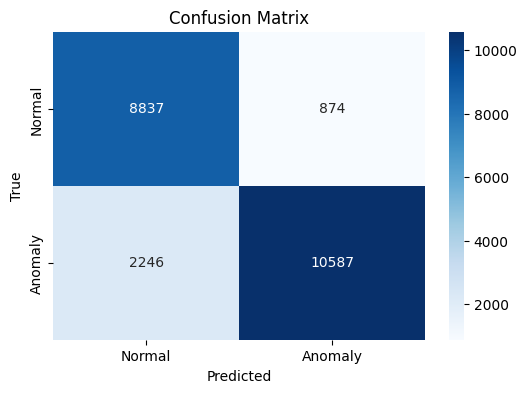

ROC AUC Score: 0.9470152778021518


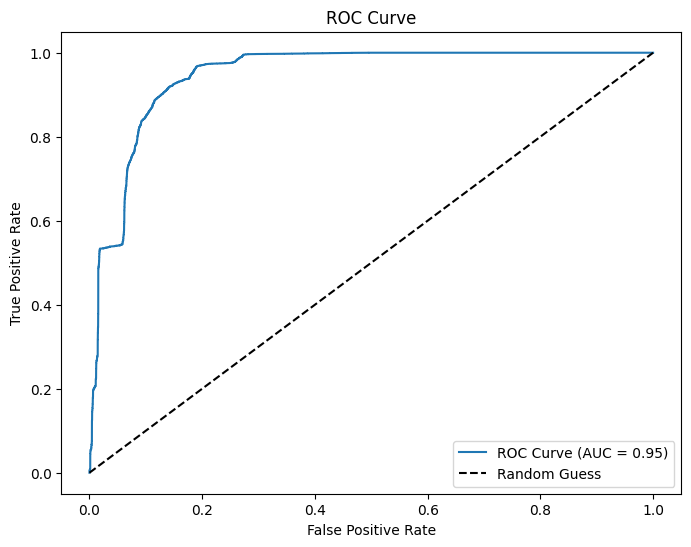

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Classify test instances as anomalies or normal
# Anomalies have reconstruction errors above the thresholdz
y_pred = [1 if error > threshold else 0 for error in mse] # 1 for anomaly, 0 for normal

# We need the true labels for the test set.
# Assuming 'normal' is the non-anomalous class and anything else is anomalous.
y_true = [0 if attack_type == 'normal' else 1 for attack_type in y_test['attack_type']]


# Evaluate the performance
print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print ROC AUC
roc_auc = roc_auc_score(y_true, mse) # Use mse as the anomaly score for ROC AUC
print(f"ROC AUC Score: {roc_auc}")

# Plot ROC Curve (Optional but recommended)
fpr, tpr, thresholds = roc_curve(y_true, mse)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Hyperparameter Tuning to Improve Accuracy


In [ ]:
!pip install keras-tuner

import keras_tuner as kt
from tensorflow.keras.optimizers import Adam # Import Adam optimizer

# Define a function to build the autoencoder model for Keras Tuner
def build_autoencoder(hp):
    input_layer = Input(shape=(input_dim,))
    x = input_layer
    # Tune the number of layers and units
    for i in range(hp.Int('num_layers', 1, 3)):
        x = Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32), activation=hp.Choice('activation', ['relu', 'tanh']))(x)

    # Latent space (bottleneck) layer
    latent_space_units = hp.Int('latent_space_units', min_value=16, max_value=128, step=16)
    x = Dense(units=latent_space_units, activation=hp.Choice('latent_activation', ['relu', 'tanh']))(x)

    # Decoder layers
    for i in range(hp.Int('num_decoder_layers', 1, 3)):
         x = Dense(units=hp.Int(f'decoder_units_{i}', min_value=32, max_value=256, step=32), activation=hp.Choice('decoder_activation', ['relu', 'tanh']))(x)


    output_layer = Dense(input_dim, activation='linear')(x)

    autoencoder_model = Model(inputs=input_layer, outputs=output_layer)

    # Tune the optimizer and learning rate
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', [0.001, 0.01, 0.0001])

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        # Use the string name for rmsprop
        opt = optimizer


    autoencoder_model.compile(optimizer=opt, loss='mean_squared_error')
    return autoencoder_model

# Initialize the Keras Tuner (e.g., RandomSearch)
tuner = kt.RandomSearch(
    build_autoencoder,
    objective='val_loss',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1, # Number of models to train per trial
    directory='keras_tuner_dir', # Directory to save results
    project_name='autoencoder_tuning')

# Run the hyperparameter search
tuner.search(X_train_normal, X_train_normal, epochs=20, validation_split=0.2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters found by Keras Tuner:")
print(best_hps.values)

# Build the best model
best_autoencoder = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_autoencoder.fit(X_train_normal, X_train_normal,
                               epochs=best_hps.get('epochs') if 'epochs' in best_hps.values else 20, # Use epochs from tuning or default
                               batch_size=best_hps.get('batch_size') if 'batch_size' in best_hps.values else 256, # Use batch_size from tuning or default
                               shuffle=True,
                               validation_split=0.2,
                               verbose=1)

print("Autoencoder training with best hyperparameters complete.")

Trial 10 Complete [00h 01m 41s]
val_loss: 0.10215554386377335

Best val_loss So Far: 0.027597201988101006
Total elapsed time: 00h 17m 15s
Best hyperparameters found by Keras Tuner:
{'num_layers': 3, 'units_0': 224, 'activation': 'tanh', 'latent_space_units': 64, 'latent_activation': 'relu', 'num_decoder_layers': 1, 'decoder_units_0': 256, 'decoder_activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.001, 'units_1': 256, 'units_2': 192, 'decoder_units_1': 96}
Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.3600 - val_loss: 0.1405
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2502 - val_loss: 0.1030
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1355 - val_loss: 0.0837
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1441 - val_loss: 0.0756
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1535 - val_loss: 0.0658
Epoch 6/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1025 - val_loss: 0.0553
Epoch 7/2

## Evaluate the performance of the anomaly detection system with the re-tuned model

Evaluate the performance of the autoencoder-based anomaly detection system with the best hyperparameters from the re-tuning using appropriate metrics such as precision, recall, F1-score, and ROC AUC on the test set.

705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
New Reconstruction error threshold (re-tuned best model): 0.01680638681663258

Classification Report (Re-tuned Best Model):
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      9711
           1       0.92      0.85      0.88     12833

    accuracy                           0.87     22544
   macro avg       0.87      0.87      0.87     22544
weighted avg       0.88      0.87      0.87     22544

Confusion Matrix (Re-tuned Best Model):


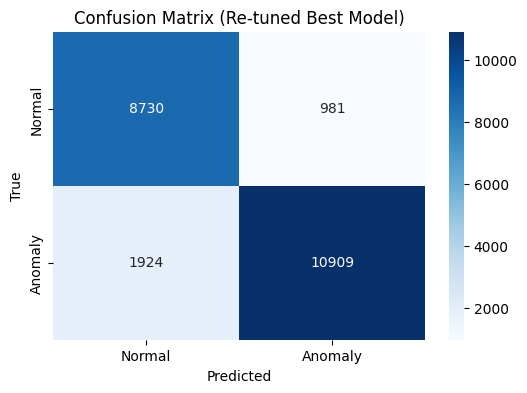

ROC AUC Score (Re-tuned Best Model): 0.9372216280619785


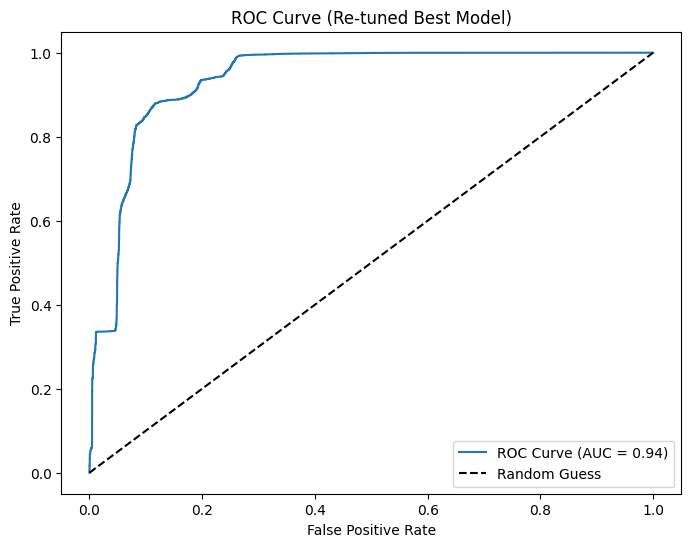

In [ ]:
# Predict the reconstruction of the test data using the best model from re-tuning
X_test_pred_best = best_autoencoder.predict(X_test)

# Calculate the reconstruction error for the test data
mse_best = np.mean(np.power(X_test - X_test_pred_best, 2), axis=1)

# Predict the reconstruction of the training data (normal traffic) using the best model from re-tuning
X_train_normal_pred_best = best_autoencoder.predict(X_train_normal)

# Calculate the reconstruction error for the training data
train_mse_best = np.mean(np.power(X_train_normal - X_train_normal_pred_best, 2), axis=1)

# Determine a new threshold based on the 95th percentile of training errors from the best model
threshold_best = np.percentile(train_mse_best, 95)

print(f"New Reconstruction error threshold (re-tuned best model): {threshold_best}")

# Classify test instances as anomalies or normal using the new threshold
y_pred_best = [1 if error > threshold_best else 0 for error in mse_best]

# We need the true labels for the test set.
# Assuming 'normal' is the non-anomalous class and anything else is anomalous.
y_true = [0 if attack_type == 'normal' else 1 for attack_type in y_test['attack_type']]

# Evaluate the performance of the re-tuned best model
print("\nClassification Report (Re-tuned Best Model):")
print(classification_report(y_true, y_pred_best))

print("Confusion Matrix (Re-tuned Best Model):")
cm_best = confusion_matrix(y_true, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Re-tuned Best Model)')
plt.show()

# Calculate and print ROC AUC for the re-tuned best model
roc_auc_best = roc_auc_score(y_true, mse_best) # Use mse_best as the anomaly score for ROC AUC
print(f"ROC AUC Score (Re-tuned Best Model): {roc_auc_best}")

# Plot ROC Curve for the re-tuned best model
fpr_best, tpr_best, thresholds_best = roc_curve(y_true, mse_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, label=f'ROC Curve (AUC = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Re-tuned Best Model)')
plt.legend()
plt.show()

## Plot Training and Validation Loss Curves

### Subtask:
Visualize the training and validation loss during the autoencoder training process.

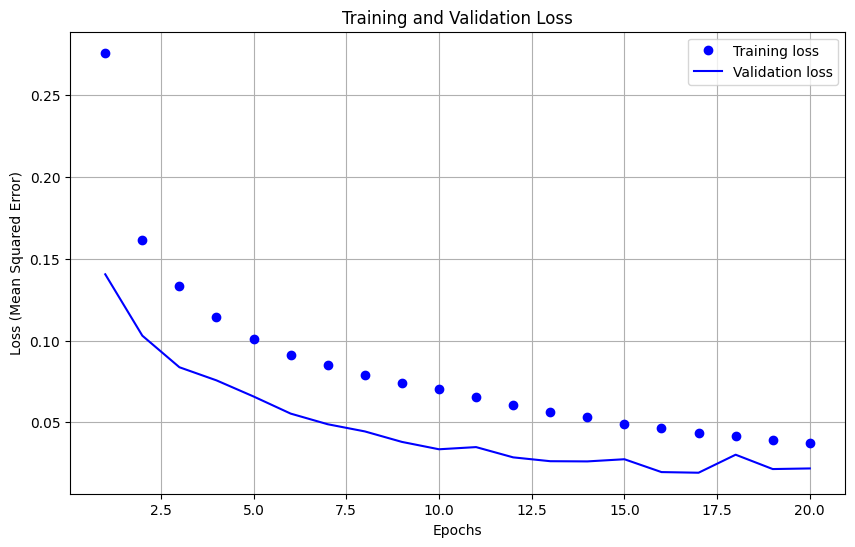

In [ ]:
import matplotlib.pyplot as plt

# Get the training and validation loss from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.show()

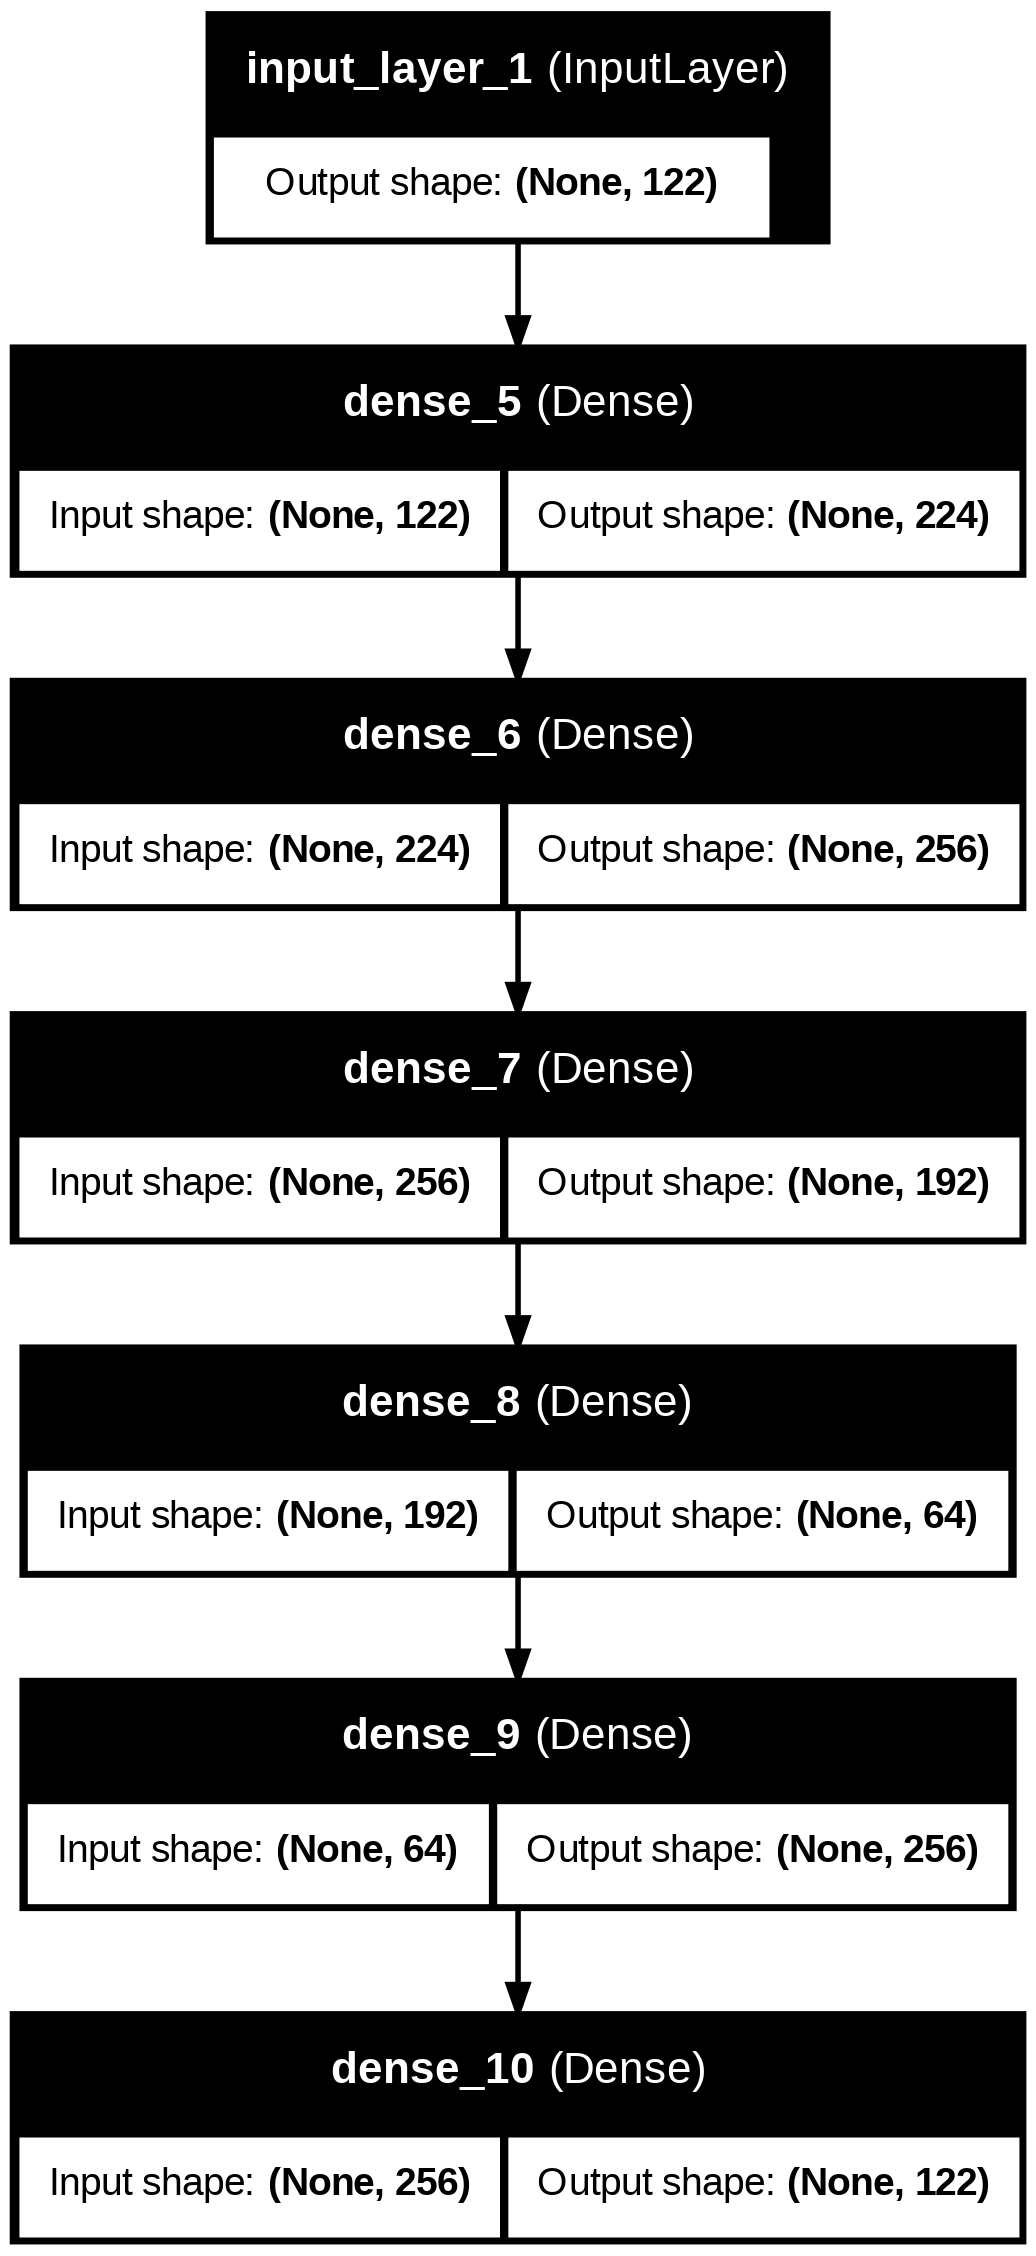

In [ ]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
# You can save the plot to a file (e.g., 'autoencoder_model.png')
# To display it directly in the notebook, ensure you have pydot and graphviz installed
plot_model(best_autoencoder, show_shapes=True, show_layer_names=True)

## Plot Reconstruction Error Distribution

### Subtask:
Visualize the distribution of reconstruction errors for normal and anomalous instances in the test set.

**Reasoning**:
Use the calculated reconstruction errors (`mse_best`) and the true labels (`y_true`) to plot density distributions of errors for both normal (label 0) and anomalous (label 1) instances in the test set.

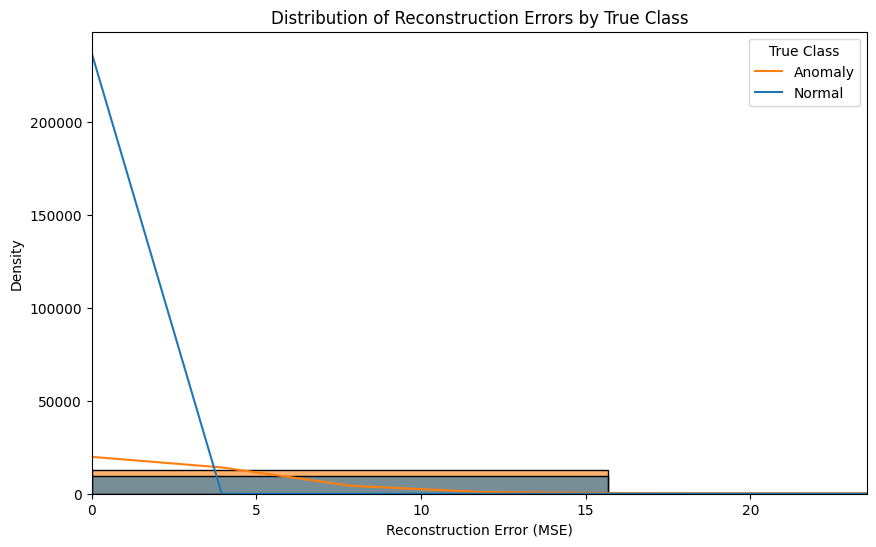

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for easier plotting with seaborn
error_df = pd.DataFrame({'reconstruction_error': mse_best,
                         'true_class': y_true})

# Plot the distribution of reconstruction errors for normal and anomalous traffic
plt.figure(figsize=(10, 6))
sns.histplot(data=error_df, x='reconstruction_error', hue='true_class', kde=True, bins=50, alpha=0.6)
plt.title('Distribution of Reconstruction Errors by True Class')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Density')
plt.legend(title='True Class', labels=['Anomaly', 'Normal']) # Correcting legend labels to match 0 and 1
plt.xlim([0, error_df['reconstruction_error'].quantile(0.995)]) # Limit x-axis for better visualization
plt.show()

##Frontend

In [ ]:
!pip install gradio

import gradio as gr
import pandas as pd
import numpy as np

# Ensure necessary objects are available from the notebook's global scope:
# best_autoencoder, threshold_best, scaler, categorical_cols, numerical_cols_encoded, X_train_normal, column_names, train_df

def preprocess_single_input(raw_input_dict):
    """
    Preprocesses a single raw input dictionary into the format expected by the autoencoder.
    Relies on global variables: scaler, categorical_cols, numerical_cols_encoded, X_train_normal.columns.
    """
    input_df = pd.DataFrame([raw_input_dict])

    # Ensure categorical columns are treated as such for get_dummies consistency
    for col in categorical_cols:
        if col in input_df.columns:
            input_df[col] = input_df[col].astype('category')

    # 1. One-hot encode categorical features
    input_df_encoded = pd.get_dummies(input_df, columns=categorical_cols)

    # 2. Align columns with the training data (X_train_normal)
    # This captures all 122 columns that X_train_normal had after encoding
    original_all_encoded_cols = X_train_normal.columns.tolist()

    # Create a new DataFrame with all expected columns, initialized to 0
    aligned_input = pd.DataFrame(0, index=[0], columns=original_all_encoded_cols)

    # Fill in the values from the current input
    for col in input_df_encoded.columns:
        if col in aligned_input.columns:
            aligned_input.loc[0, col] = input_df_encoded.loc[0, col]

    # 3. Scale numerical features
    # numerical_cols_encoded is the list of numerical columns in the *encoded* dataframe
    # that were scaled during training. We must ensure only these specific columns are transformed.
    cols_to_scale = [col for col in numerical_cols_encoded if col in aligned_input.columns]

    # Check if there are columns to scale before attempting to transform
    if cols_to_scale:
        aligned_input[cols_to_scale] = scaler.transform(aligned_input[cols_to_scale])

    return aligned_input

def predict_anomaly(duration, protocol_type, service, flag, src_bytes, dst_bytes,
                    land, wrong_fragment, urgent, hot, num_failed_logins, logged_in,
                    num_compromised, root_shell, su_attempted, num_root, num_file_creations,
                    num_shells, num_access_files, num_outbound_cmds, is_host_login,
                    is_guest_login, count, srv_count, serror_rate, srv_serror_rate,
                    rerror_rate, srv_rerror_rate, same_srv_rate, diff_srv_rate,
                    srv_diff_host_rate, dst_host_count, dst_host_srv_count,
                    dst_host_same_srv_rate, dst_host_diff_srv_rate, dst_host_same_src_port_rate,
                    dst_host_srv_diff_host_rate, dst_host_serror_rate, dst_host_srv_serror_rate,
                    dst_host_rerror_rate, dst_host_srv_rerror_rate):

    # Collect inputs into a dictionary, excluding 'attack_type' and 'label' from column_names
    input_data_dict = {col: val for col, val in locals().items() if col in column_names and col not in ['attack_type', 'label']}

    processed_input = preprocess_single_input(input_data_dict)

    # Predict reconstruction for the single input
    # Add a check for the model's expected input shape
    if processed_input.shape[1] != best_autoencoder.input_shape[1]:
        return "Error: Input feature count does not match model's expected input."

    reconstruction = best_autoencoder.predict(processed_input, verbose=0)
    reconstruction_error = np.mean(np.power(processed_input - reconstruction, 2), axis=1)[0]

    # Classify based on threshold
    if reconstruction_error > threshold_best:
        prediction = f"Anomaly Detected! (Reconstruction Error: {reconstruction_error:.4f})"
    else:
        prediction = f"Normal Traffic. (Reconstruction Error: {reconstruction_error:.4f})"

    return prediction

# Get unique values for categorical features from the training data for dropdowns
protocol_type_choices = train_df['protocol_type'].unique().tolist()
service_choices = train_df['service'].unique().tolist()
flag_choices = train_df['flag'].unique().tolist()

# Define Gradio inputs based on the original column names
# Provide reasonable default values
inputs = [
    gr.Number(value=0, label="duration"),
    gr.Dropdown(choices=protocol_type_choices, value=protocol_type_choices[0], label="protocol_type"),
    gr.Dropdown(choices=service_choices, value=service_choices[0], label="service"),
    gr.Dropdown(choices=flag_choices, value=flag_choices[0], label="flag"),
    gr.Number(value=0, label="src_bytes"),
    gr.Number(value=0, label="dst_bytes"),
    gr.Number(value=0, label="land"),
    gr.Number(value=0, label="wrong_fragment"),
    gr.Number(value=0, label="urgent"),
    gr.Number(value=0, label="hot"),
    gr.Number(value=0, label="num_failed_logins"),
    gr.Number(value=0, label="logged_in"),
    gr.Number(value=0, label="num_compromised"),
    gr.Number(value=0, label="root_shell"),
    gr.Number(value=0, label="su_attempted"),
    gr.Number(value=0, label="num_root"),
    gr.Number(value=0, label="num_file_creations"),
    gr.Number(value=0, label="num_shells"),
    gr.Number(value=0, label="num_access_files"),
    gr.Number(value=0, label="num_outbound_cmds"),
    gr.Number(value=0, label="is_host_login"),
    gr.Number(value=0, label="is_guest_login"),
    gr.Number(value=0, label="count"),
    gr.Number(value=0, label="srv_count"),
    gr.Number(value=0.0, label="serror_rate"),
    gr.Number(value=0.0, label="srv_serror_rate"),
    gr.Number(value=0.0, label="rerror_rate"),
    gr.Number(value=0.0, label="srv_rerror_rate"),
    gr.Number(value=0.0, label="same_srv_rate"),
    gr.Number(value=0.0, label="diff_srv_rate"),
    gr.Number(value=0.0, label="srv_diff_host_rate"),
    gr.Number(value=0, label="dst_host_count"),
    gr.Number(value=0, label="dst_host_srv_count"),
    gr.Number(value=0.0, label="dst_host_same_srv_rate"),
    gr.Number(value=0.0, label="dst_host_diff_srv_rate"),
    gr.Number(value=0.0, label="dst_host_same_src_port_rate"),
    gr.Number(value=0.0, label="dst_host_srv_diff_host_rate"),
    gr.Number(value=0.0, label="dst_host_serror_rate"),
    gr.Number(value=0.0, label="dst_host_srv_serror_rate"),
    gr.Number(value=0.0, label="dst_host_rerror_rate"),
    gr.Number(value=0.0, label="dst_host_srv_rerror_rate")
]

outputs = gr.Textbox(label="Prediction")

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_anomaly,
    inputs=inputs,
    outputs=outputs,
    title="Network Intrusion Detection System (Autoencoder)",
    description="Enter network traffic features to detect anomalies. The reconstruction error indicates how 'unusual' the traffic is compared to normal training data. A higher error suggests an anomaly."
)

# Launch the interface (this will create a temporary public link)
iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e30164dc4cd8bb4582.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
